## week10: seq2seq practice
### Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [1]:
# Uncomment this cell in Colab

! wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_msai/week0_10_embeddings_and_seq2seq/names -O names

--2024-12-05 12:45:03--  https://raw.githubusercontent.com/girafe-ai/ml-course/23s_msai/week0_10_embeddings_and_seq2seq/names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55868 (55K) [text/plain]
Saving to: ‘names’

names               100%[===================>]  54.56K  --.-KB/s    in 0.01s   

2024-12-05 12:45:04 (4.05 MB/s) - ‘names’ saved [55868/55868]



In [ ]:
import os

start_token = "<"
end_token = ">"
pad_token = "_"

with open("names") as f:
    names = f.read()[:-1].split("\n")
    names = [start_token + line + end_token for line in names]

In [ ]:
print("n samples = ", len(names))
for x in names[::1000]:
    print(x)

n samples =  7944
<Abagael>
<Claresta>
<Glory>
<Liliane>
<Prissie>
<Geeta>
<Giovanne>
<Piggy>


max length = 17


(array([1.900e+01, 2.720e+02, 0.000e+00, 9.270e+02, 0.000e+00, 1.877e+03,
        0.000e+00, 2.049e+03, 0.000e+00, 1.447e+03, 0.000e+00, 8.460e+02,
        0.000e+00, 3.510e+02, 0.000e+00, 1.160e+02, 0.000e+00, 2.400e+01,
        0.000e+00, 1.000e+01, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00]),
 array([ 4.  ,  4.52,  5.04,  5.56,  6.08,  6.6 ,  7.12,  7.64,  8.16,
         8.68,  9.2 ,  9.72, 10.24, 10.76, 11.28, 11.8 , 12.32, 12.84,
        13.36, 13.88, 14.4 , 14.92, 15.44, 15.96, 16.48, 17.  ]),
 <BarContainer object of 25 artists>)

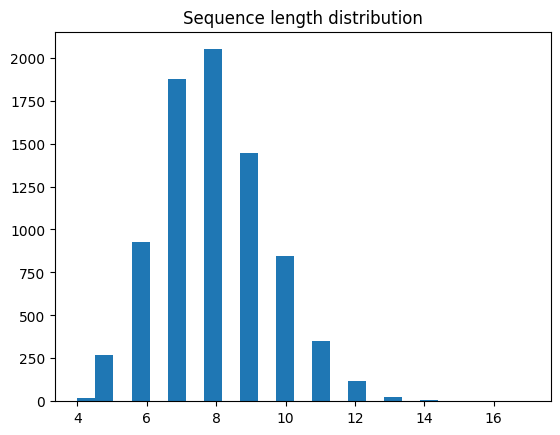

In [ ]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title("Sequence length distribution")
plt.hist(list(map(len, names)), bins=25)

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [ ]:
# all unique characters go here
tokens = set()
for name in names:
    tokens.update(set(name))

tokens.update({pad_token})
tokens = list(tokens)

num_tokens = len(tokens)
print("num_tokens = ", num_tokens)

assert (
    50 < num_tokens < 60
), "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens =  58


In [ ]:
pad_token in tokens

True

### Convert characters to integers

Torch is built for crunching numbers, not strings.
To train our neural network, we'll need to replace characters with their indices in tokens list.

Let's compose a dictionary that does this mapping.

In [ ]:
id_to_token = list(tokens)
token_to_id = {token: idx for idx, token in enumerate(id_to_token)}

In [ ]:
print(token_to_id)
print(f"{token_to_id['<']=}")
print(f"{token_to_id['>']=}")
print(f"{token_to_id[pad_token]=}")

{'a': 0, 'O': 1, 'T': 2, 'x': 3, 'q': 4, 'u': 5, '_': 6, 'f': 7, 'z': 8, 'h': 9, 'p': 10, 'J': 11, 'w': 12, 'Q': 13, 'G': 14, 'X': 15, 's': 16, 'm': 17, 'S': 18, 'y': 19, 'R': 20, 'U': 21, 'e': 22, 'j': 23, '-': 24, 'P': 25, 'K': 26, 'l': 27, '>': 28, '<': 29, ' ': 30, 'c': 31, 'H': 32, 'g': 33, 'd': 34, 'I': 35, 'V': 36, 'W': 37, 'F': 38, 'n': 39, 'Y': 40, 'o': 41, 'k': 42, 'N': 43, 't': 44, 'i': 45, 'L': 46, 'v': 47, 'M': 48, 'B': 49, 'D': 50, "'": 51, 'E': 52, 'b': 53, 'Z': 54, 'C': 55, 'A': 56, 'r': 57}
token_to_id['<']=29
token_to_id['>']=28
token_to_id[pad_token]=6


In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert (
        token_to_id[tokens[i]] == i
    ), "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [ ]:
def to_matrix(
    names_batch,
    max_len=None,
    pad=token_to_id[pad_token],
    dtype="int32",
    batch_first=False,
):
    """Casts a list of names into rnn-digestable matrix"""

    max_len = max_len or max(map(len, names_batch))
    names_ix = np.zeros([len(names_batch), max_len], dtype) + pad

    for i in range(len(names_batch)):
        line_ix = [token_to_id[c] for c in names_batch[i]][:max_len]
        names_ix[i, : len(line_ix)] = line_ix

    if not batch_first:  # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [ ]:
# Example: cast 4 random names to matrices, pad with zeros
print("\n".join(names[::2000]))
print(to_matrix(names[::2000]).T)
print({t: token_to_id[t] for t in names[0]})

<Abagael>
<Glory>
<Prissie>
<Giovanne>
[[29 56 53  0 33  0 22 27 28  6]
 [29 14 27 41 57 19 28  6  6  6]
 [29 25 57 45 16 16 45 22 28  6]
 [29 14 45 41 47  0 39 39 22 28]]
{'<': 29, 'A': 56, 'b': 53, 'a': 0, 'g': 33, 'e': 22, 'l': 27, '>': 28}


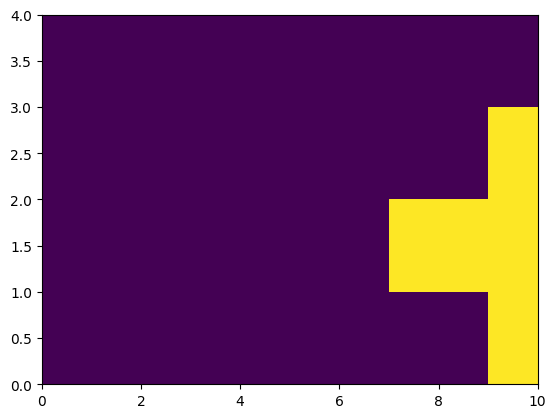

In [ ]:
plt.pcolormesh(to_matrix(names[::2000]).T == token_to_id[pad_token])

# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="https://github.com/girafe-ai/ml-course/blob/23f_msu_dl/week0_05_embeddings_and_seq2seq/rnn.png?raw=1" width=480>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """

    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)  # YOUR CODE HERE

        h_next = self.rnn_update(x_and_h)  # YOUR CODE HERE
        h_next = torch.tanh(h_next)  # YOUR CODE HERE

        assert h_next.size() == h_prev.size()

        # compute logits for next character probs
        logits = self.rnn_to_logits(h_next)  # YOUR CODE

        return h_next, logits

    def initial_state(self, batch_size):
        """return rnn state before it processes first input (aka h0)"""
        return torch.zeros(batch_size, self.num_units, requires_grad=True)




In [ ]:
char_rnn = CharRNNCell()

### RNN loop

Once we've defined a single RNN step, we can apply it in a loop to get predictions on each step.

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    max_length, batch_size = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    all_logits = []

    for x_t in batch_ix:
        hid_state, logits_next = char_rnn(
            x_t, hid_state
        )  # <-- here we call your one-step code
        all_logits.append(logits_next)

    return torch.stack(all_logits, dim=1)

In [ ]:
batch_ix = to_matrix(names[:5])
print(f'{batch_ix=}')
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print(f'{batch_ix.size()=}')

all_logits = rnn_loop(char_rnn, batch_ix)

batch_ix=array([[29, 29, 29, 29, 29],
       [56, 56, 56, 56, 56],
       [53, 53, 53, 53, 53],
       [ 0,  0, 53, 53, 53],
       [33, 33, 22, 22, 45],
       [ 0,  0, 28, 19, 28],
       [22, 45,  6, 28,  6],
       [27, 27,  6,  6,  6],
       [28, 28,  6,  6,  6]], dtype=int32)
batch_ix.size()=torch.Size([9, 5])


In [ ]:
# (batch_size, max_length, num_tokens)
all_logits.shape

torch.Size([5, 9, 58])

### Likelihood and gradients

We can now train our neural network to minimize crossentropy (maximize log-likelihood) with the actual next tokens.

To do so in a vectorized manner, we take `batch_ix[:, 1:]` - a matrix of token ids shifted i step to the left so i-th element is acutally the "next token" for i-th prediction

In [ ]:
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_id[pad_token])
# (batch_size, max_length - 1)
actual_next_tokens = batch_ix[1:, :].T

# (batch_size, max_length-1, num_tokens)
pred_logits = all_logits[:, :-1, :]

pred_logits_flattened = pred_logits.reshape(
    (pred_logits.shape[0] * pred_logits.shape[1], -1)
)

actual_next_tokens_flattened = actual_next_tokens.reshape(-1)

pred_logits.size()=torch.Size([5, 8, 58])
pred_logits_flattened.size()=torch.Size([40, 58])


In [ ]:
# (batch_size * max_length-1, num_tokens)
print(pred_logits_flattened.shape)
# (batch_size * max_length - 1)
print(actual_next_tokens_flattened.shape)

torch.Size([40, 58])
torch.Size([40])


In [ ]:
loss = loss_func(pred_logits_flattened, actual_next_tokens_flattened)

In [ ]:
loss.backward()

In [ ]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, (
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method."
        % (w.size(),)
    )

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

In [ ]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

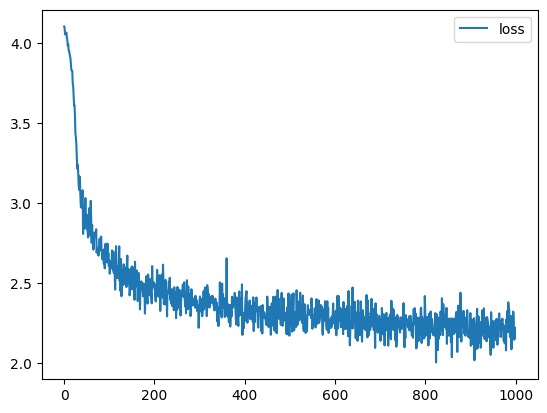

In [ ]:
MAX_LENGTH = 16

for i in range(1000):
    opt.zero_grad()
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    all_logits = rnn_loop(char_rnn, batch_ix)

    # compute loss
    # <YOUR CODE>
    actual_next_tokens = batch_ix[1:, :].T

    pred_logits = all_logits[:, :-1, :]
    pred_logits_flattened = pred_logits.reshape(
        (pred_logits.shape[0] * pred_logits.shape[1], -1)
    )
    actual_next_tokens_flattened = actual_next_tokens.reshape(-1)
    loss = loss_func(pred_logits_flattened, actual_next_tokens_flattened)
    # train with backprop
    loss.backward()
    opt.step()
    # <YOUR CODE>

    history.append(loss.item())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff.
All we need is the single rnn step function you have defined in `char_rnn.forward`.

In [ ]:
def generate_sample(
    char_rnn, seed_phrase="<", max_length=MAX_LENGTH, temperature=1.0, pretty_print=True
):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    output = "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])
    if pretty_print:
        output = output.split(">")[0][1:]
    return output

In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=2.5))

JbYtqEaG
JhsVoodidec
Ea-y
Ma<Arrtk_cJmura
Joddfindny
HDbAb
Katasosedxydl
IvXKo-malmXkuet
nQmovyldGnynRte
JwoaelivozvNmp


In [ ]:
for _ in range(50):
    print(generate_sample(char_rnn, seed_phrase="<AAASJAA"))

AAASJAAlen
AAASJAAnta
AAASJAAna
AAASJAAn
AAASJAAf
AAASJAAn
AAASJAAna
AAASJAAnnell
AAASJAA
AAASJAAnnh
AAASJAAnee
AAASJAAne
AAASJAAc
AAASJAA
AAASJAAmeyd
AAASJAAn
AAASJAAnie
AAASJAA
AAASJAAn
AAASJAAn
AAASJAAdna
AAASJAAc
AAASJAAn
AAASJAAn
AAASJAAnne
AAASJAAn
AAASJAA
AAASJAAnke
AAASJAAn
AAASJAAd
AAASJAAn
AAASJAAnee
AAASJAA
AAASJAAnna
AAASJAAnki
AAASJAAra
AAASJAAneada
AAASJAAnnelen
AAASJAA
AAASJAAnica
AAASJAAdne
AAASJAAnne
AAASJAAniaA
AAASJAAd
AAASJAAnce
AAASJAA
AAASJAAsy
AAASJAA
AAASJAAne
AAASJAAn
